<a href="https://colab.research.google.com/github/yosuke7040/atmacup8/blob/main/%E8%AC%9B%E5%BA%A71_%E3%83%87%E3%83%BC%E3%82%BF%E3%82%92%E7%9C%BA%E3%82%81%E3%81%A6_submission_%E3%82%92%E3%81%99%E3%82%8B(original).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents

* データを知る
    * スキーマを理解する
    * 現象を理解する
    * 実際にデータを眺める
* python を使ったデータの理解
    * train / test の Report をさっくり作る
    * 学習用のデータと予測するデータの差分を知る
* モデリングのための特徴量作成
    * 連続変数の特徴量
    * Boolean の特徴量
* LightGBM でモデル作る
    * CrossValidation とは / なんで CrossValidation するの?
    * LightGBM でのモデリング・パラメータ
    * 特徴重要度 (FeatureImporatnce) の可視化
    * モデルを使って予測・submissionの作成

In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用

sns.set_style('ticks')

In [ ]:
INPUT_DIR = '/analysis/data/atmaCup8/inputs/'
OUTPUT_DIR = '/analysis/data/atmaCup8/outputs/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
train_df.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


## データを知る

まずはじめに、どういうデータを取り扱って、何を予測してその結果がどのように評価されるのかについての理解を深めます。

### スキーマ(構造)を確認する

一番初めにやることは、コードを書くことではなくデータのスキーマと実際にどういうデータが入っているのかを確認することです。

自分が使える情報は何か・それはどのような構造を持っているか・実際にどういう値が入っているかをしっかりと把握してください。
今回のデータセットは `train.csv` および `test.csv` しかないシンプルなものでしたが、一般には複数のテーブルが 1-1 もしくは 1-m / n-m の関係で紐付いていることが多いです。複雑な関係性になると、うっかり見落としていたと言ったことが起こりえますので、予測の元になる情報として何が使えるのかに関してもれなく理科しておくことは基本的ですがとても大事です。

### 現象を理解する

次に「このデータはどういうふうに作られているか」について考えてみてください。特殊なデータを除いて、データとは何らかの行動のあしあとですから物理的・時間的な制約を多く受けます。あしあとに関して想像をふくらませることで Machine Learning のアルゴリズムに対してよりよい情報を作って渡すことができます。

### 実際に眺める

データは実際に自分で見てください。エクセルで開いて、フィルタなどを活用しながらデータを確認することでデータの肌感を知ることができます。

例えば...

* Null がめっちゃ同時に起こっている → 特定の場合には2つの情報が同時に欠落するようなオペレーションになっているかも? というようなインサイト
* テキストのカラムでの表記ゆれ。人間が見たほうがすぐわかります。

## pythonを使ったデータの理解

### train / test の Report をさっくり作る

pandas profiling というライブラリがあり、こちらを使うとデータフレームの統計量を一気に確認することが可能です。簡単な使い方は `ProfileReport` class に可視化したいデータフレームを渡して repot を作り `to_file` を呼び出して html ファイルとして保存する方法です。

保存した html をブラウザなどで開くと以下のような統計量をカラムごとに確認できてとても便利です。

* ユニークな値の数
* 頻度の高い値
* 意味の無いカラムや Null が多いカラムかどうか ...etc

In [ ]:
report = ProfileReport(train_df)
report.to_file(os.path.join(OUTPUT_DIR, 'train_report.html'))

### 学習用のデータと予測するデータの差分を知る

* ref: [カテゴリ値を持つカラムのベン図 | takapy san](https://www.guruguru.science/competitions/13/discussions/9983c457-6fcc-4346-a6ae-6c5eb3e785ec/)

学習データと予測データは(当たり前ですが)別のデータです。この別の度合いが強すぎる場合、特にカテゴリのカラムでテストデータ・学習データでかぶっていないものが多い場合には注意をする必要があります。(より一般的に言うとテストデータと学習データの分布が異なるもの一般が要注意な特徴量になります。)

分布が違いすぎるというのは即ち「学習していない状況で予測をする」ことです。
分布が違うと、学習データで見積もった予測性能とテストデータでの予測性能が乖離してしまう場合がありますので、そういったカラムを特徴量として使う場合には注意が必要です。

> 例: 「Nintendo64」のゲームだったらとても良く予測できるモデルを作って、テストで「PS4」のゲームを予測させて良い性能が出るでしょうか。

Text(0.5, 1.0, 'Year_of_Release')

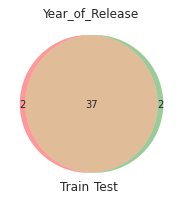

In [ ]:
c = 'Year_of_Release'

fig, ax = plt.subplots(figsize=(5, 3))
venn2(
    subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
    set_labels=('Train', 'Test'),
    ax=ax
)
ax.set_title(c)

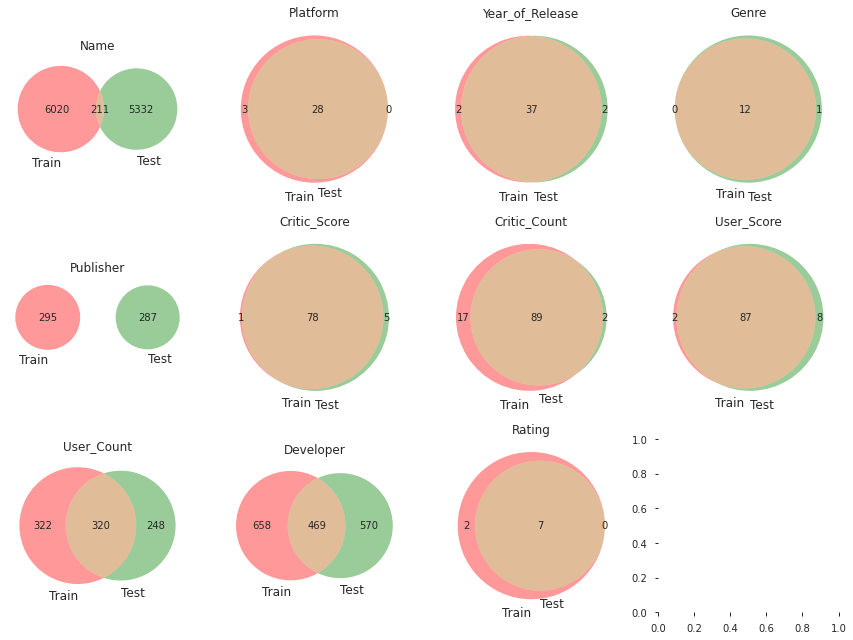

In [ ]:
columns = test_df.columns
n_figs = len(columns)
n_cols = 4
n_rows = n_figs // n_cols + 1

fig, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), ncols=n_cols, nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
    venn2(
        subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
        set_labels=('Train', 'Test'),
        ax=ax
    )
    ax.set_title(c)

fig.tight_layout()

### その他の方法

* [Sweetvizを用いた訓練データとテストデータの比較 | hakubishin3 san](https://www.guruguru.science/competitions/13/discussions/dc25339c-dedc-453e-aaeb-c52543ccd3bc/)

## モデリングのための特徴量作成

### 特徴量とは何か

予測変数に紐付いた説明変数のことを「特徴量」と呼びます。近年の進歩でたくさんのアルゴリズムが開発され予測能力は向上していますが、アルゴリズムに入力するデータは人間が用意しなくてはなりません。この予測の元になるデータを特徴量とよび、アルゴリズムが理解しやすい特徴量を作ることを特徴量エンジニアリングと呼びます。

### どうやって作れば良い?

基本的に人間が予測する時と同じように「何があったら予測しやすいかなあ」を考えていくことが多いです。

### 連続変数の特徴量

連続変数の場合そのままモデルが解釈出来るため、基本的にはそのまま予測に用いることが可能です。

#### 欠損値の処理

通常欠損値があると欠損のことを考慮する必要があります(モデルによっては欠損値が扱えない場合があるからです)。その場合平均値や中央値、更には別の方法で欠損を埋める必要がありますが lightGBM などの GBDT は欠損をそのまま自然に扱えるため、基本的に気にする必要はありません。

#### 暗黙的な仮定を意識する

連続変数とみなす場合には、その大小関係に意味があると思っていることと同値であることに注意してください。大小関係に意味がない値の場合には、連続変数ではなくて、カテゴリ変数とみなして処理を行ったほうが適切な場合があります。

勾配ブースティングのように連続値とみなしてもある程度うまくやってくれるアルゴリズムではそこまでシビアに考える必要はありませんが、線形モデルのように値の大小と予測結果が線形に比例するようなモデルでは大小に意味がないものを連続値として扱うと予測性能が悪化する場合があります。  
(例えば「ユーザーごとの缶コーヒー購買量」を予測するときに「年齢」を数値としてみなしてよいか?)

よく知られている例では時間 (0-24)があります。時間は 0 と 24 がつながっている (1週して元に戻ってくる) ので1次元で表現せずに極座標の角度として捉えて cos(hour / 12 pi) / sin (hour / 12 * pi) の2次元で表現する、等があります。

In [ ]:
train_df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

In [ ]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    return output_df

def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count', 
        'User_Score', 
        'User_Count',
        'Year_of_Release'
    ]
    return input_df[use_columns].copy()

In [ ]:
assert len(create_continuous_features(train_df)) == len(train_df)

In [ ]:
assert create_continuous_features(train_df.head()).equals(create_continuous_features(train_df.head()))

### Booleanの特徴量

特定の条件を満たしているかどうか, を表す特徴量です。例えばテキストカラムに特定の文字列が存在しているかどうか、などが該当します。

In [ ]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()
    
    texts = [
        'japan', 'nintendo'
    ]
    
    for t in texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

In [ ]:
create_boolean_feature(train_df).sum()

Developer_has_japan       23
Developer_has_nintendo    88
dtype: int64

In [ ]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [ ]:
from tqdm import tqdm

def to_feature(input_df):
    processors = [
        create_continuous_features,
        create_boolean_feature
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with timer(prefix='create ' + func.__name__ + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [ ]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 2/2 [00:00<00:00, 60.08it/s]

create create_continuous_features 0.005[s]
create create_boolean_feature 0.025[s]
create create_continuous_features 0.005[s]
create create_boolean_feature 0.025[s]


In [ ]:
assert len(test_feat_df) == len(test_df)

## LightGBM による学習

特徴量を作成できたので、次に LightGBM による学習を行っていきます。この時大事になるのが交差検証 (Cross Validation) という考え方です。

### Cross Validation とは

Cross Validation とは学習用のデータセットを複数に分割してそれぞれの分割で学習・検証のデータセットを作り、モデルの性能を見積もる枠組みのことです。

### なんで Cross Validation するの?

なぜわざわざ分割するの? (そのまま全部学習で使っちゃえばいいじゃない?) と思われるのが普通だと思います。なぜ分割するかというと学習データの中で今の枠組みの性能(枠組みと言っているのは特徴量・モデルの構成もろもろ全部が含まれるためです)を評価したいからです。手元で評価ができないとLBに出してみて一喜一憂するしかなくなり、結果publicLBにオーバーフィットしてしまうのでよろしくないです。

> 仕事的な観点で言ってもLBに出すというのはデプロイ(本番へ反映すること)ですから、本番に出さないとモデルの良し悪しがわからないのはよろしくないですよね?

一番ナイーブな戦略は `KFold` と呼ばれるものです。これは何も考えずにとにかくランダムに学習データを分割します。

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0041.png)

その他にターゲットの分布が同じになるように分割する Stratified と呼ばれる方法もあります。(今回行なうのはこの方法です)

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0071.png)

あとは「各分割で特定のグループが重ならないようにする」Group K Fold もよく使われます。(よく見ると 0 ~ 4 で group の行の色が被らないようになっているのわかりますか?)

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0051.png)

その他にも時系列で区切る time split という方法もあります。どれを使えばよいかは test データがどのように構成されているか依存なので、つどつどデータを見て決定します。

### CrossValidation の注意点

cross validation を行なう場合には train / test の関係性と cv の各 fold での学習・検証データの関係性が出来る限り似た関係性になる必要があります。これは fold ごとの学習で、train 全体で学習したときの test での性能を近似する必要があるためです。したがって今渡されている train / test の関係性を考えたうえで CV の方法についても考える必要があります。(特にtestが未来の情報である場合などとても大切です)

### LightGBM による CrossValidation を用いた学習

In [ ]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_log_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=10):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        
        # global sales はゼロ以下になるわけがないので 0 以下は 0 に丸める
        pred_i = np.where(pred_i < 0, 0, pred_i)
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {mean_squared_log_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_log_error(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

### parameter について

LightGBM などの GBDT のパラメータは、そこまでセンシティブではありません。しかし、内部的にどういう意味を持つのかを知っておくと、問題ごとにどういうパラメータが良いかの感覚がわかったり、チューニングする際にも有効なパラメータに絞ってチューニングできますので、重要な変数に関してはその意味についてざっと目を通しておくことをおすすめします。

以下参考文献です。

* [勾配ブースティングで大事なパラメータの気持ち](https://nykergoto.hatenablog.jp/entry/2019/03/29/%E5%8B%BE%E9%85%8D%E3%83%96%E3%83%BC%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%A7%E5%A4%A7%E4%BA%8B%E3%81%AA%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E6%B0%97%E6%8C%81%E3%81%A1): 僕の書いた記事。日本語です。
* [Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html): lightGBM 公式のパラメータチューニングガイド。英語です。

In [ ]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = train_df['Global_Sales'].values

In [ ]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [ ]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 154.074
[20]	valid_0's rmse: 150.936
[30]	valid_0's rmse: 151.524
Early stopping, best iteration is:
[22]	valid_0's rmse: 150.577
fit fold=1 0.300[s]
Fold 0 RMSLE: 1.5432
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 240.156
[20]	valid_0's rmse: 234.979
[30]	valid_0's rmse: 234.198
[40]	valid_0's rmse: 233.793
Early stopping, best iteration is:
[37]	valid_0's rmse: 233.526
fit fold=2 0.030[s]
Fold 1 RMSLE: 1.4675
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 146.814
[20]	valid_0's rmse: 146.388
Early stopping, best iteration is:
[16]	valid_0's rmse: 145.77
fit fold=3 0.031[s]
Fold 2 RMSLE: 1.5313
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 145.936
[20]	valid_0's rmse: 140.966
[30]	valid_0's rmse: 140.182
[40]	valid_0's rmse: 139.359
[50]	valid_0's rmse: 139.978
Early stopping, best iteration is:
[

### Note

* lightGBM を `RMSE` の意味で学習させました (`objective="rmse"`)。RMSEはノイズが正規分布に従っていると仮定したモデルですが、今回のデータでは成り立っているでしょうか。
* 評価指標は `RMSLE` で `RMSE` とずれています。できれば `RMSLE` の意味で最適化することが良いはずです (ことこのコンペにおいては). RMSLE の意味で最適化する方法はないでしょうか。

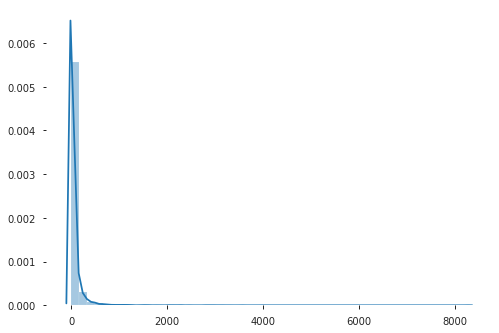

In [ ]:
sns.distplot(y)

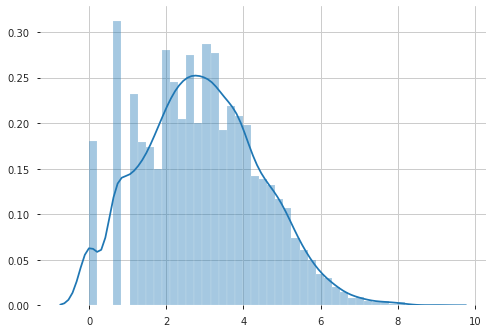

In [ ]:
ax = sns.distplot(np.log(y))
ax.grid()

### 特徴重要度の確認

LightGBM など木系のモデルではどの特徴量で分割を行ってどれだけ目的変数を説明しているかを特徴重要度 (feature importance) として出力することができます。これを見ることで

* どの特徴量が大事なのか
* どの特徴量はあまり大事ではないか

といった特徴量に関する情報を得ることができます。これによって、例えば重要となった特徴量を使う別の特徴を考えたり、反対に大事ではない特徴を削ったりといったインサイトを得ることが可能です。

In [ ]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

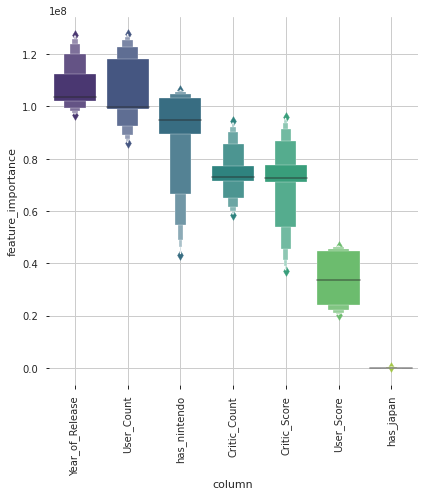

In [ ]:
fig, ax = visualize_importance(models, train_feat_df)

In [ ]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.where(pred < 0, 0, pred)
sub_df = pd.DataFrame({ 'Global_Sales': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, 'simple_submission.csv'), index=False)

Submission する前には予測値がまともかどうかちゃんと見ておきます。(貴重なsubmissionを無駄にしないため)

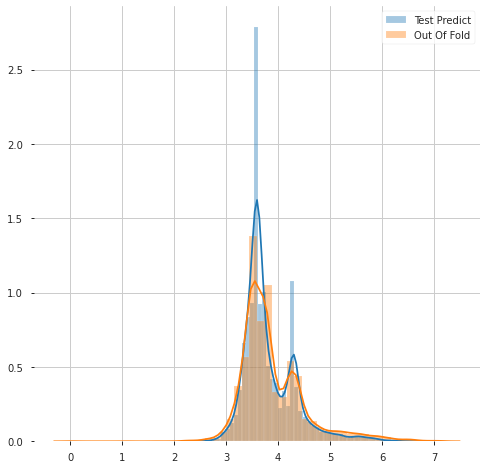

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot(np.log1p(oof), label='Out Of Fold')
ax.legend()
ax.grid()

### Future Work

* データをより良く見て、性質を理解する (EDA)
* 特徴量をより凝ったものにする

これらは次回の講座で扱います!